# Getting started with Julia and Trixi.jl

[Trixi.jl](https://github.com/trixi-framework/Trixi.jl) is a numerical simulation framework for hyperbolic conservation laws written in [Julia](https://julialang.org). A key objective for the framework is to be useful to both scientists and students. Therefore, next to having an extensible design with a fast implementation, Trixi is focused on being easy to use for new or inexperienced users, including the installation and postprocessing procedures.

The primary goal of this notebook is give a live demonstration of Julia and Trixi during a talk given at the Numerical Analysis Seminar at Lund University in January 2021. Here, we will show how to use Trixi for setting up and running simulations, how to visualize the results, and how to extend Trixi with new functionality. The notebook and a description of how to run it with Jupyter are available at [GitHub](https://github.com/trixi-framework/talk-2021-julia-adaptive-multi-physics-simulations).

*Note:* Jupyter notebooks (like the Julia REPL) maintain an internal *state*, i.e., the different cells share a common variable space. This means that if you change a variable in a later cell and then reuse it (explicitly or implicitly) in an earlier cell, the results might change unexpectedly. Thus if in doubt, re-run the entire notebook *in order*.

**NOTE: This repository will be updated several times prior to the talk, with the final version of the notebook to be uploaded at least one day before.**

**Table of contents**
1. [Quickstart](#Quickstart)
2. [Mixing an elixir: creating a Trixi simulation from scratch](#Mixing-an-elixir:-creating-a-Trixi-simulation-from-scratch)
   1. [The basics](#The-basics)
   2. [Using a different initial condition](#Using-a-different-initial-condition)
   3. [Adaptive mesh refinement](#Adaptive-mesh-refinement)
   4. In-situ visualization
3. Advanced usage
   1. Solution analysis during a simulation
   2. Running convergence tests
   3. Postprocessing with Trixi2Vtk and ParaView

## Quickstart

To quickly get up and running with Trixi, load the package (only required once) and start an example 2D simulation with the following commands (to execute the cell, select it and hit `Shift-Enter`):

In [1]:
using Trixi

trixi_include(default_example())


████████╗██████╗ ██╗██╗  ██╗██╗
╚══██╔══╝██╔══██╗██║╚██╗██╔╝██║
   ██║   ██████╔╝██║ ╚███╔╝ ██║
   ██║   ██╔══██╗██║ ██╔██╗ ██║
   ██║   ██║  ██║██║██╔╝ ██╗██║
   ╚═╝   ╚═╝  ╚═╝╚═╝╚═╝  ╚═╝╚═╝

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 2                                                                │
│ mesh: ………………………………………………………………… TreeMesh{2, Trixi.SerialTree{2}} with length 341                 │
│ equations: …………………………………………………… LinearScalarAdvectionEquation2D                                  │
│ initial condition: ……………………………… initial_condition_convergence_test                               │
│ boundary conditions: ………………………… 4                                                                

`trixi_include(...)` is a function that loads a Julia file and executes its contents. We call such files that contain a valid Trixi setup **elixirs**. `default_example()` is part of the Trixi package and returns the path to an example elixir for running a 2D linear advection simulation.

**Please note that during the first invocation this may take a minute or two, since Julia has to compile all functions at first usage.**

The results of a Trixi simulation can easily be visualized with the [Plots](https://github.com/JuliaPlots/Plots.jl) package. Simply load `Plots` and call the `plot(...)` command with the argument `sol`. By convention, in all our elixirs `sol` is the variable name that contains the result of a simulation.

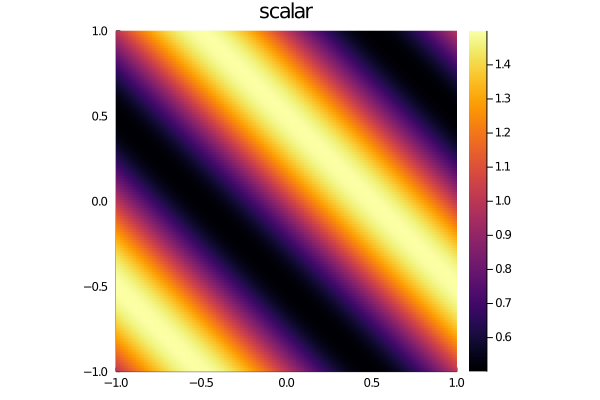

In [2]:
using Plots

plot(sol)

## Mixing an elixir: creating a Trixi simulation from scratch

### The basics

Let's have a look at what an elixir looks like. Generally speaking, the following components are required:
* an **equation** object that contains all physics-specific data and functionality
* a **solver** that represents the numerical method and its algorithms
* a **mesh** that holds the grid data
* a **semidiscretization** that encapsulates equation, solver, and mesh, together with initial and boundary conditions

The semidiscretization object is then used to create an `ODEProblem` that can be solved with one of the solvers for ordinary differential equations (ODEs) from the [OrdinaryDiffEq](https://github.com/SciML/OrdinaryDiffEq.jl) package.

In the following are the contents of a *minimum* elixir that produces the same result as the `trixi_include(...)` command above (the elixir can be found in [examples/elixir_advection_simple.jl](examples/elixir_advection_simple.jl)):

In [3]:
# Load necessary packages
using OrdinaryDiffEq
using Trixi

# Create equations
advectionvelocity = (1.0, 1.0)
equations = LinearScalarAdvectionEquation2D(advectionvelocity)

# Create DGSEM solver for polynomial degree = 3
solver = DGSEM(3, flux_lax_friedrichs)

# Create a uniformely refined mesh with periodic boundaries
coordinates_min = (-1, -1) # minimum coordinates
coordinates_max = ( 1,  1) # maximum coordinates
mesh = TreeMesh(coordinates_min, coordinates_max,
                initial_refinement_level=4,
                n_cells_max=30_000)

# Create semidiscretization with all spatial discretization-related components
semi = SemidiscretizationHyperbolic(mesh, equations,
                                    initial_condition_convergence_test,
                                    solver)

# Create ODE problem from semidiscretization with time span from 0.0 to 1.0
ode = semidiscretize(semi, (0.0, 1.0));

# Evolve ODE problem in time using OrdinaryDiffEq's `solve` method
sol = solve(ode, CarpenterKennedy2N54(williamson_condition=false), dt=2.5e-2);

And that's it. In this minimum example, there is no output to the terminal/notebook, thus only the lack of errors tells us that everything went smoothly. However, as before, we can visualize the solution by plotting it with the `plot` function of the `Plots` package:

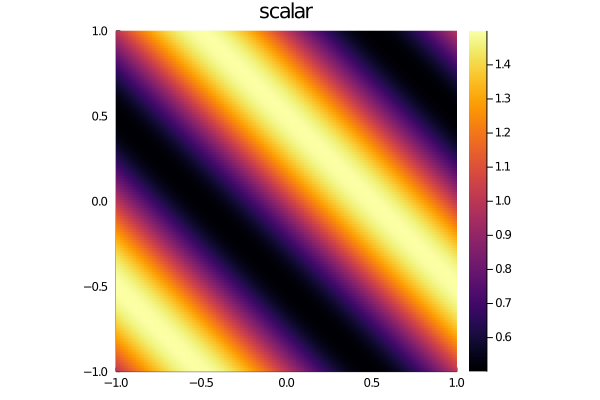

In [4]:
using Plots

plot(sol)

As you can see from the snippet above, the entirety of a simulation setup is defined in pure Julia: There are no "special" parameter files, and changing a simulation setup means to modify its elixir. For example, we can change the adection velocity by creating a new `LinearScalarAdvectionEquation2D` object with a different set of speeds and re-run the simulation with the following code:

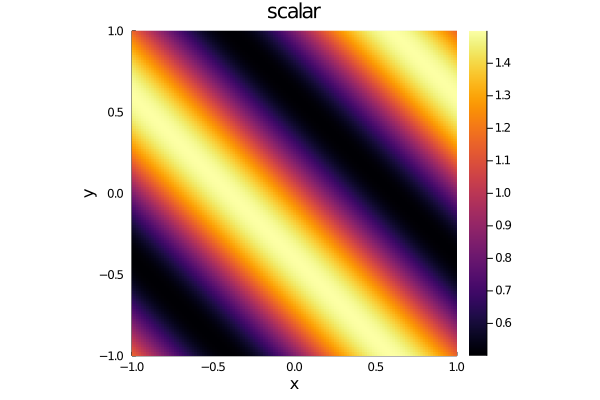

In [5]:
# Create equations with different advection velocity
advectionvelocity = (1.0, 0.1)
equations = LinearScalarAdvectionEquation2D(advectionvelocity)

# Recreate semidiscretization with the new `equations` object
semi = SemidiscretizationHyperbolic(mesh, equations,
                                    initial_condition_convergence_test,
                                    solver)

# Create and solve ODE problem
ode = semidiscretize(semi, (0.0, 1.0));
sol = solve(ode, CarpenterKennedy2N54(williamson_condition=false), dt=2.5e-2);

# Plot result with axis labels
plot(sol, xguide="x", yguide="y")

In addition to the different advection velocities, we have added `x` and `y` labels to the axes to illustrate that you can use all of the regular plotting features of the `Plots` package.

## Using a different initial condition

So far we have only used functionality that is provided by Trixi. With its modular architecture, however, it is easy to extend Trixi's functionality to your liking. Let's define a new initial condition with a cosine-shaped pulse at its center:

In [6]:
function cosine_pulse(x, t, equations::LinearScalarAdvectionEquation2D)
  halfwidth = 0.3
  radius = sqrt(x[1]^2 + x[2]^2)

  if radius > halfwidth
    u = 0.0
  else
    u = 0.2 * cos(pi/2 * radius / halfwidth)
  end

  return Trixi.@SVector [u]
end

cosine_pulse (generic function with 1 method)

Now we can use this function for the initial condition parameter in the semidiscretization, re-run the simulation, and plot the results:

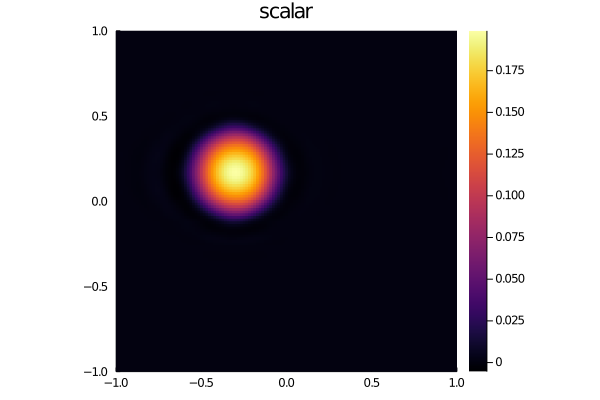

In [7]:
# Recreate semidiscretization with the new initial condition
semi = SemidiscretizationHyperbolic(mesh, equations,
                                    cosine_pulse, # <-- here is the new function
                                    solver)

# Create and solve ODE problem
ode = semidiscretize(semi, (0.0, 1.7));
sol = solve(ode, CarpenterKennedy2N54(williamson_condition=false), dt=2.5e-2);

# Plot result
plot(sol)

## Adaptive mesh refinement

In the previous examples, we have always used a static, uniform mesh. This means we did not fully exploit one of Trixi's fundamental building blocks: the underlying hierarchical Cartesian mesh. With its ability to locally refine the mesh in a solution-adaptive way, it can be used to greatly speed up simulations with no or minimal loss in overall accuracy. The following image series of the grid for an expanding blast wave simulation ([elixir](https://github.com/trixi-framework/Trixi.jl/blob/v0.3.7/examples/2d/elixir_euler_blast_wave_amr.jl) available with Trixi) at $t = [0.2, 0.6, 1.0]$ (left to right) illustrates how the mesh resolution is increased only where needed.

<div align="center">
  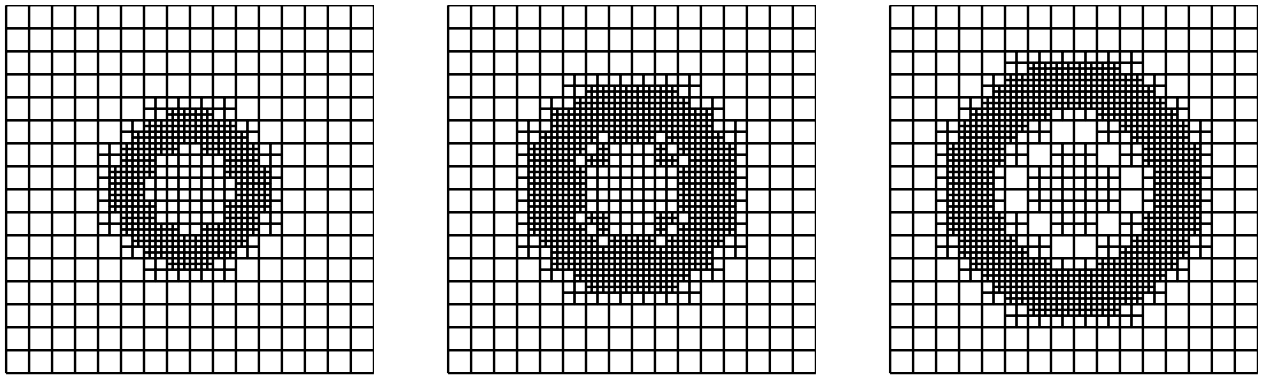
</div>

With Trixi, you can statically refine the mesh upfront, adaptively refine it during a simulation, or use a combination of both. Here, we will focus on how to do adaptive mesh refinement (AMR), which is implemented in Trixi as a **step callback**. A callback is an algorithmic entity that is registered with the ODE solver and then *called* in regular intervals to perform certain tasks: *step* callbacks are run after each time step, while *stage* callbacks are run after each stage of the ODE solver.

Using callbacks instead of hard-coding all features in the main loop has the advantage that it allows to extend Trixi with new functionality without having to modify its code directly. Beyond AMR, in Trixi we make use of callbacks also for tasks such as solution analysis, file I/O, in-situ visualization, or time step size calculation.

Building upon the previous example, we will now introduce the `AMRCallback` to adaptively refine the mesh around the cosine pulse. The callback also requires the definition of an *AMR controller*, i.e., an object that tells the AMR algorithms which cells to refine/coarsen:

In [8]:
# Use a simple AMR controller that to refine cells between level 4 and level 6, based on the maximum value of the solution in an element
amr_controller = ControllerThreeLevel(semi, IndicatorMax(semi, variable=first),
                                      base_level=4,
                                      med_level=5, med_threshold=0.05,
                                      max_level=6, max_threshold=0.15);

# Create the AMR callback that will be called every 5 time steps
amr_callback = AMRCallback(semi, amr_controller,
                           interval=5,
                           adapt_initial_condition=true,
                           adapt_initial_condition_only_refine=true);

The `AMRCallback` can now be passed to the ODE solver and will be invoked (i.e., performs adaptive mesh refinement) every 5 time steps:

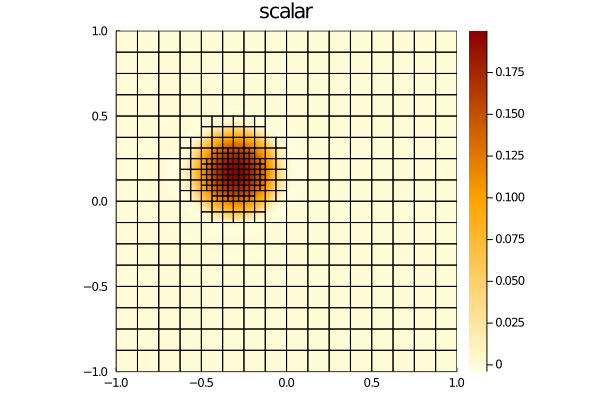

In [9]:
# Create and solve ODE problem, using the previously constructed AMR callback
ode = semidiscretize(semi, (0.0, 1.7));
sol = solve(ode, CarpenterKennedy2N54(williamson_condition=false), callback=amr_callback, dt=6.25e-3);

# Plot result
pd = PlotData2D(sol)
plot(pd, seriescolor=:heat)
plot!(getmesh(pd))

Here we also changed the color scheme and added the mesh lines to the plot to demonstrate how the mesh is locally refined around the cosine pulse.

## In-situ visualization

Another example for features 